# Exploring Stock Fundamentals
Using Python I want to explore what stock fundamentals have the greatest effect on the increase of a stock price the following quarter. The past few years I have been following William J. O'Neil's investing model CAN SLIM. According to this model one of the most important predictors of a stocks increase in price is Earnings Per Share (EPS), Annual Earnings Growth, and Return on Equity. 

The investing method also has some other more subjective readings such as whether the company has a great new product or CEO. Another huge aspect of the model is the time to buy, the market must be in a uptrend, the volume must be greater than average, and a stock pattern must exist. For this analysis I will focus strictly on the C and A of the CANSLIM model and see how the recommended fundamentals affect the stocks price. During the process I will explore if other fundamentals are greater or equal predictors and whether I should add these to my stock analysis.

My hypothesis is that EPS, ROE, and Sales Increase alone will not be correlated with stock price. I suspect together we will see slightly more correlation, but nothing significant. The stock market is notoriously chaotic and if it was really that simple I'd be writing this analysis on a Yacht right now.

You can read more about the CAN SLIM investing model here https://en.wikipedia.org/wiki/CAN_SLIM

In [58]:
#Importing the tools needed for this analysis. Changing some view options so my data isn't cut off in Jupyter Notebooks
import pandas as pd
import numpy as np
from scipy import stats
import bs4
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
%matplotlib inline
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 800)
plt.style.use('ggplot')

## Importing Helpful Functions
I wrote several functions to help with our analysis below. 

In [45]:
from canslim import AnnualChange, QuarterlyChange, PriceTarget, StreakIncrease, outliers_z_score, explore, AccelIncrease

# 1 Collecting Stock Data
I explored the internet in depth for historical fundamentals data and chose this site stockpup.com/data/ . Better data existed on sites like Quandl, but they cost money. The data on stockpup.com has a good amount of companies and contains the fundamentals per quarter for these companies.

To save myself the work of downloading each file individually I decided to write a quick scraper to parse the website stockpup.com and grab all the CSV files. To do this I used BeautifulSoup

In [3]:
url = 'http://www.stockpup.com/data/'
html = requests.get(url)
soup = bs4.BeautifulSoup(html.text, "html.parser")

In [4]:
#Create an Empty Dictionary to hold our CSV links
links = {}

#Loop over all <a href> tags on stockpup.com/data.
for link in soup.find_all('a', href=True):
    #If the link contains a .csv file. It will set the key of the links dictionary to the stock ticker and then the value to the url for the csv data.
    if '.csv' in str(link):
        links[re.match("(.*?)(?=_)",str(link)).group().split('/')[2]] = ('http://www.stockpup.com' + link.get('href'))

In [5]:
''' Commenting out below for speed of kernel run

#Next we will loop over each csv in our links dictionary
for link in links.items():
    #read each spreadsheet into a dataframe called data.
    data = pd.read_csv(link[1])
    #Create a symbol feature in the dataframe
    data['symbol'] = link[0]
    #concat the data dataframe into overall dataframe stocks
    stocks = pd.concat([stocks,data])

#drop the null values from the data.
stocks.dropna(inplace=True)
#Read the data to a csv.
stocks.to_csv('stocks.csv')
'''

" Commenting out below for speed of kernel run\n\n#Next we will loop over each csv in our links dictionary\nfor link in links.items():\n    #read each spreadsheet into a dataframe called data.\n    data = pd.read_csv(link[1])\n    #Create a symbol feature in the dataframe\n    data['symbol'] = link[0]\n    #concat the data dataframe into overall dataframe stocks\n    stocks = pd.concat([stocks,data])\n\n#drop the null values from the data.\nstocks.dropna(inplace=True)\n#Read the data to a csv.\nstocks.to_csv('stocks.csv')\n"

In [6]:
#We have data saved so we can quickly load the Dataframe now from a csv without having to run our scraper above
stocks = pd.read_csv('data/stocks.csv')
#Drop Unnamed Column
stocks.drop('Unnamed: 0', axis=1,inplace=True)

#From exploring below found that there are a lot of str values for 'None'. Replacing these with np.nan
stocks = stocks.replace('None', np.nan)

# 2 Quick Data Exploration
The first step I took was to do a quick exploration of my data. I was trying to understand how much data I collected from my  scraper and how dirty it was.
<br /><br />

In [7]:
stocks.head(5)

,Asset turnover,Assets,Book value of equity per share,Capital expenditures,Cash at end of period,Cash change during period,Cash from financing activities,Cash from investing activities,Cash from operating activities,Cumulative dividends per share,Current Assets,Current Liabilities,Current ratio,Dividend payout ratio,Dividend per share,EPS basic,EPS diluted,Earnings,Earnings available for common stockholders,Equity to assets ratio,Free cash flow per share,Goodwill & intangibles,Liabilities,Long-term debt,Long-term debt to equity ratio,Net margin,Non-controlling interest,P/B ratio,P/E ratio,Preferred equity,Price,Price high,Price low,Quarter end,ROA,ROE,Revenue,Shareholders equity,Shares,Shares split adjusted,Split factor,symbol
0,0.55,8698000000,14.02,60000000,2887000000,209000000,37000000,-67000000,215000000,20.62,4397000000,1361000000,3.2307,0.8925,0.149,-0.99,-0.99,-320000000,-320000000,0.5199,0.48,2974000000,4172000000,1800000000,0.3981,0.0425,4000000,4.7,33.48,0,70.3,75.0,65.6,2018-01-31,0.0235,0.0428,1211000000,4522000000,322476579,322476579,1.0,A
1,0.55,8426000000,14.96,58000000,2678000000,115000000,-106000000,-60000000,288000000,20.47,4169000000,1263000000,3.3009,0.2477,0.130,0.54,0.54,177000000,177000000,0.5733,0.71,2968000000,3591000000,1801000000,0.3728,0.153,4000000,4.43,32.83,0,63.37,68.52,58.22,2017-10-31,0.084,0.1511,1189000000,4831000000,323018027,323018027,1.0,A
2,0.55,8261000000,14.32,43000000,2563000000,174000000,29000000,-101000000,228000000,20.34,3996000000,1241000000,3.22,0.2581,0.132,0.55,0.54,175000000,175000000,0.5578,0.57,2987000000,3650000000,1801000000,0.3908,0.1436,3000000,4.31,33.11,0,58.6,61.84,55.36,2017-07-31,0.079,0.1441,1114000000,4608000000,321828003,321828003,1.0,A
3,0.55,8016000000,13.61,43000000,2389000000,148000000,-67000000,-43000000,257000000,20.21,3800000000,1187000000,3.2013,0.2718,0.132,0.51,0.5,164000000,164000000,0.5454,0.67,2941000000,3641000000,1802000000,0.4122,0.1341,3000000,3.92,33.7,0,52.23,55.99,48.47,2017-04-30,0.0738,0.1345,1102000000,4372000000,321337443,321337443,1.0,A
4,0.55,7872000000,13.33,32000000,2241000000,-48000000,-58000000,-101000000,116000000,20.08,3635000000,1089000000,3.3379,0.3011,0.132,0.52,0.52,168000000,168000000,0.5459,0.26,2974000000,3572000000,1802000000,0.4194,0.1195,3000000,3.5,33,0,46.2,49.48,42.92,2017-01-31,0.0653,0.119,1067000000,4297000000,322300905,322300905,1.0,A


In [8]:
stocks.shape

(58743, 42)

In [9]:
stocks.columns

Index(['Asset turnover', 'Assets', 'Book value of equity per share',
       'Capital expenditures', 'Cash at end of period',
       'Cash change during period', 'Cash from financing activities',
       'Cash from investing activities', 'Cash from operating activities',
       'Cumulative dividends per share', 'Current Assets',
       'Current Liabilities', 'Current ratio', 'Dividend payout ratio',
       'Dividend per share', 'EPS basic', 'EPS diluted', 'Earnings',
       'Earnings available for common stockholders', 'Equity to assets ratio',
       'Free cash flow per share', 'Goodwill & intangibles', 'Liabilities',
       'Long-term debt', 'Long-term debt to equity ratio', 'Net margin',
       'Non-controlling interest', 'P/B ratio', 'P/E ratio',
       'Preferred equity', 'Price', 'Price high', 'Price low', 'Quarter end',
       'ROA', 'ROE', 'Revenue', 'Shareholders equity', 'Shares',
       'Shares split adjusted', 'Split factor', 'symbol'],
      dtype='object')

In [10]:
len(stocks.symbol.unique())

756

In [11]:
print(min(stocks['Quarter end']), '-', max(stocks['Quarter end']))

1993-06-30 - 2018-04-01


The data I was able to scrape contains roughly 42 fundamentals for 756 companies from the years of 1993 to 2018. Not a bad haul, but only a fraction of the amount of companies which publically trade on the stock market so any findings will need to be taken with a healthy grain of salt

# 3 Data Munging
The data will need to be cleaned quite a bit. This includes converting data types and deciding what to do with NULL values

In [12]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58743 entries, 0 to 58742
Data columns (total 42 columns):
Asset turnover                                54908 non-null object
Assets                                        58716 non-null object
Book value of equity per share                58716 non-null object
Capital expenditures                          58743 non-null int64
Cash at end of period                         58620 non-null object
Cash change during period                     58029 non-null object
Cash from financing activities                57804 non-null object
Cash from investing activities                57801 non-null object
Cash from operating activities                57813 non-null object
Cumulative dividends per share                58743 non-null float64
Current Assets                                48817 non-null object
Current Liabilities                           48796 non-null object
Current ratio                                 48794 non-null object
Dividen

## Converting Datatypes
Majority of our datatypes are objects when they should really be floats (measurements) or datetimes. 

Convert every column that isn't 'symbol' or 'Quarter end' to a float

Convert Quarter end to datetime

In [13]:
#Convert every column other than symbol or Quarter end to float.
stocks[stocks.columns.difference(['symbol', 'Quarter end'])] = stocks[stocks.columns.difference(['symbol', 'Quarter end'])].astype(float)
#Convert Quarter end to datetime
stocks['Quarter end'] = pd.to_datetime(stocks['Quarter end'])
#Generate a Year and Month column from Quarter end
stocks['Year'] = stocks['Quarter end'].dt.year
stocks['Month'] = stocks['Quarter end'].dt.month

#save original columns in case needed later
og_columns = stocks.select_dtypes(include=['float']).columns

## NULL Values

In [14]:
round(stocks.isnull().sum()/len(stocks)*100, 2)

Asset turnover                                 6.53
Assets                                         0.05
Book value of equity per share                 0.05
Capital expenditures                           0.00
Cash at end of period                          0.21
Cash change during period                      1.22
Cash from financing activities                 1.60
Cash from investing activities                 1.60
Cash from operating activities                 1.58
Cumulative dividends per share                 0.00
Current Assets                                16.90
Current Liabilities                           16.93
Current ratio                                 16.94
Dividend payout ratio                         16.60
Dividend per share                             0.00
EPS basic                                      1.15
EPS diluted                                    9.21
Earnings                                       1.05
Earnings available for common stockholders     1.05
Equity to as

Most concerning out of these nulls is the fact that .79% of our price data is NULL.  

In [15]:
stocks[stocks['Price'].isnull()].head(10)

,Asset turnover,Assets,Book value of equity per share,Capital expenditures,Cash at end of period,Cash change during period,Cash from financing activities,Cash from investing activities,Cash from operating activities,Cumulative dividends per share,Current Assets,Current Liabilities,Current ratio,Dividend payout ratio,Dividend per share,EPS basic,EPS diluted,Earnings,Earnings available for common stockholders,Equity to assets ratio,Free cash flow per share,Goodwill & intangibles,Liabilities,Long-term debt,Long-term debt to equity ratio,Net margin,Non-controlling interest,P/B ratio,P/E ratio,Preferred equity,Price,Price high,Price low,Quarter end,ROA,ROE,Revenue,Shareholders equity,Shares,Shares split adjusted,Split factor,symbol,Year,Month
91,1.01,2.678000e+10,-354.97,595000000.0,717000000.0,113000000.0,1.257000e+09,-1.107000e+09,-3.700000e+07,537.23,1.024100e+10,1.009800e+10,1.0142,0.0000,0.000,0.86,0.76,2.890000e+08,2.890000e+08,NaN,-28.32,0.0,3.470200e+10,9.208000e+09,NaN,0.0170,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2013-09-30,0.0172,NaN,6.828000e+09,-7.922000e+09,335598131.0,22317275.0,0.0665,AMR,2013,9
92,1.02,2.621600e+10,-368.23,919000000.0,604000000.0,-2000000.0,1.738000e+09,-2.897000e+09,1.157000e+09,537.23,9.635000e+09,1.066900e+10,0.9031,NaN,0.000,0.65,0.59,2.200000e+08,2.200000e+08,NaN,10.67,0.0,3.443200e+10,8.354000e+09,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2013-06-30,-0.0039,NaN,6.449000e+09,-8.216000e+09,335525399.0,22312439.0,0.0665,AMR,2013,6
93,1.04,2.385200e+10,-375.68,859000000.0,606000000.0,126000000.0,5.310000e+08,-1.088000e+09,6.830000e+08,537.23,7.525000e+09,9.990000e+09,0.7533,NaN,0.000,-1.02,-1.02,-3.410000e+08,-3.410000e+08,NaN,-7.89,0.0,3.222800e+10,7.021000e+09,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2013-03-31,-0.0232,NaN,6.098000e+09,-8.376000e+09,335271557.0,22295558.0,0.0665,AMR,2013,3
94,1.03,2.351000e+10,-358.23,670000000.0,480000000.0,-28000000.0,6.270000e+08,-3.670000e+08,-2.880000e+08,537.23,7.072000e+09,9.304000e+09,0.7601,NaN,0.000,0.78,0.78,2.630000e+08,2.630000e+08,NaN,-42.97,161000000.0,3.149700e+10,7.116000e+09,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2012-12-31,-0.0776,NaN,5.937000e+09,-7.987000e+09,335271557.0,22295558.0,0.0665,AMR,2012,12
95,1.03,2.392700e+10,-330.78,419000000.0,508000000.0,137000000.0,-1.040000e+08,3.960000e+08,-1.550000e+08,537.23,7.303000e+09,9.586000e+09,0.7618,NaN,0.000,-0.71,-0.71,-2.380000e+08,-2.380000e+08,NaN,-25.75,0.0,3.130200e+10,6.489000e+09,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2012-09-30,-0.1333,NaN,6.429000e+09,-7.375000e+09,335271557.0,22295558.0,0.0665,AMR,2012,9
96,1.02,2.472600e+10,-402.23,450000000.0,371000000.0,-4000000.0,-4.400000e+07,-6.150000e+08,6.550000e+08,537.23,7.984000e+09,1.006600e+10,0.7932,NaN,0.000,-0.72,-0.72,-2.410000e+08,-2.410000e+08,NaN,9.19,0.0,3.369400e+10,6.716000e+09,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2012-06-30,-0.1292,NaN,6.452000e+09,-8.968000e+09,335271557.0,22295558.0,0.0665,AMR,2012,6
97,0.99,2.451100e+10,-389.58,226000000.0,375000000.0,92000000.0,1.000000e+07,-9.850000e+08,1.067000e+09,537.23,7.778000e+09,9.543000e+09,0.8150,NaN,0.000,-4.95,-4.95,-1.660000e+09,-1.660000e+09,NaN,37.72,0.0,3.319700e+10,6.891000e+09,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2012-03-31,-0.1296,NaN,6.037000e+09,-8.686000e+09,335271557.0,22295558.0,0.0665,AMR,2012,3
201,1.35,1.403145e+09,11.94,19939000.0,100067000.0,14730000.0,-2.177600e+07,-1.972700e+07,5.623300e+07,0.23,NaN,NaN,NaN,0.0308,0.012,0.32,0.32,2.617900e+07,2.617900e+07,0.6898,0.45,206938000.0,4.352060e+08,4.211200e+07,0.0435,0.0613,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2010-09-30,0.0828,0.1209,4.521500e+08,9.679390e+08,81062750.0,81062750.0,1.0000,AAN,2010,9
202,1.36,1.341001e+09,11.71,15397000.0,85337000.0,-27330000.0,-1.982000e+06,-2.160200e+07,-3.746000e+06,0.21,NaN,NaN,NaN,0.0280,0.012,0.30,0.30,2.443500e+07,2.443500e+07,0.7072,-0.24,205598000.0,3.926890e+08,5.442800e+07,0.0574,0.0617,0.0,NaN,NaN,0.0,NaN,NaN,NaN,2010-06-30,0.0839,0.1227,4.449990e+08,9.483120e+08,81003810.0,81003810.0,1.0000,AAN,2010,6
203,1.3

Working with time series data I'm concerned if I remove the null price data that when I go to find the percentage change of our fundamentals it will no longer be by quarter. For this reason I kept them in and will fill them later.

# Prepare Target. Price Percentage Change
The data only contains data on the Price so I below I will create our target columns of Price Percentage increase. In order to do this I need to put my data into order by date and then group by symbol and then compare the previous quarter to the current quarter. Once I have the change I need to shift the rows so that I can use this as our target variable.

To see the logic behind how I did this please see the function above titled PriceTarget. 

*Why Stock Price Percentage Increase versus stock price increase*

Many stocks trade at wildly different prices so if a stock such as Berkshire Hathaway trades which trades roughly \$300k a share would to raise by \$20k that would be a percentage increase of 6.67% which is a modest gain. However, this large of gain would look huge in our statistical models as they will assume all stocks are equal, and would look much much better than say a \$50 increase on a \$50 stock which would be a whopping 100% increase and much better.

In [16]:
#Generating Price Target columns. Both total change and percentage change
pt = PriceTarget()
stocks = pt.fit_transform(stocks)
stocks.head(5)[['Year','Month','symbol','Price','Price target', 'Pricep target']]

Column(s) Generated : ['Price_qchange']
Targets Created : ['Price target','Pricep target']


,Year,Month,symbol,Price,Price target,Pricep target
72,2000,1,A,59.63,55.37,0.928559
71,2000,4,A,115.00,-44.25,-0.384783
70,2000,7,A,70.75,-19.84,-0.280424
69,2000,10,A,50.91,2.12,0.041642
68,2001,1,A,53.03,-13.03,-0.245710


## Distribution of the Price Percentage Change Column

count    57432.000000
mean         0.030692
std          0.157101
min         -0.990512
25%         -0.046582
50%          0.030781
75%          0.104164
max          1.992486
Name: Pricep target, dtype: float64


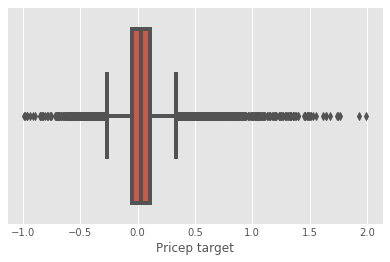

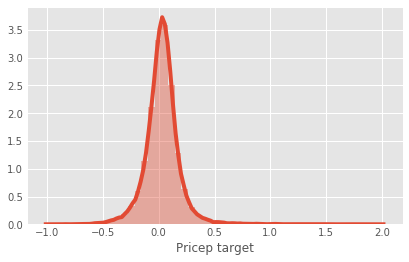

In [59]:
print(stocks['Pricep target'].describe())
sns.boxplot(stocks['Pricep target'])
plt.show()
sns.distplot(stocks['Pricep target'].dropna())

## Exploring Outliers

Looks like we have a few outliers that are really skewing our price percentage change columns. Below I take a look at the outliers to see if they are caused by error or if its just the nature of our data. 

In [18]:
#Want to look at the quarter before to confirm the price really did change that drastically. 
stocks.loc[list(stocks[stocks['Pricep target'] > 2].index -1)+ \
           list(stocks[stocks['Pricep target'] > 2].index)+ \
           list(stocks[stocks['Pricep target'] > 2].index + 1)] \
      .sort_values(['symbol', 'Year', 'Month']) \
      [['symbol', 'Year', 'Month', 'Price', 'Price target','Pricep target']]

,symbol,Year,Month,Price,Price target,Pricep target
8993,BJS,1996,6,1.61,0.09,0.055901
8992,BJS,1996,9,1.70,3.85,2.264706
8991,BJS,1996,12,5.55,0.30,0.054054
10038,BTU,2015,6,56.40,-54.53,-0.966844
10037,BTU,2015,9,1.87,15.66,8.374332
10036,BTU,2015,12,17.53,-12.59,-0.718197
10034,BTU,2016,6,1.49,0.14,0.093960
10033,BTU,2016,9,1.63,8.46,5.190184
10032,BTU,2016,12,10.09,-6.51,-0.645193
10031,BTU,2017,3,3.58,-3.05,-0.851955


| BTU 2017 | CIT 2009 | MAA 2017|
| --- | --- | --- |
| ![NN](./img/BTU2017.png) | ![NN](./img/CIT2009.png) | ![NN](./img/MAA2017.png)


Found that the data has some errors in it. I checked our outliers on google to see if the stock price really did fall or rise as much as it shows in the data. The pictures above show us a few of our examples. In the month of June for BTU in 2017 never came close to reaching .53, same goes for CIT2009, and MAA in 2017. 

## Cleaning outliers due to data errors
Because I want to keep this analysis quick I will just fill the large outliers with NaN values. Then will perform a forward fill on the data. We will choose 2 for our cutoff value as this is a little greater than 2 standard deviations from the mean. Also, we explored these values above and found majority were errors.

In [19]:
stocks.loc[stocks[stocks['Pricep target'] > 2].index -1, 'Price'] = np.nan

In [20]:
stocks.loc[list(stocks[stocks['Pricep target'] > 2].index -1)+ \
           list(stocks[stocks['Pricep target'] > 2].index)+ \
           list(stocks[stocks['Pricep target'] > 2].index + 1)] \
            .sort_values(['symbol', 'Year', 'Month']) \
            ['Price'] = stocks.loc[list(stocks[stocks['Pricep target'] > 2].index -1)+ \
           list(stocks[stocks['Pricep target'] > 2].index)+ \
           list(stocks[stocks['Pricep target'] > 2].index + 1)] \
            .sort_values(['symbol', 'Year', 'Month']) \
            ['Price'].fillna(method='ffill')

In [21]:
#Regenerate our target columns after cleaning price data
pt = PriceTarget()
stocks = pt.fit_transform(stocks)

Column(s) Generated : ['Price_qchange']
Targets Created : ['Price target','Pricep target']


## Distribution of Price target without outliers

count    57432.000000
mean         0.030692
std          0.157101
min         -0.990512
25%         -0.046582
50%          0.030781
75%          0.104164
max          1.992486
Name: Pricep target, dtype: float64


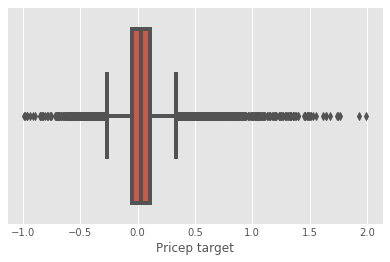

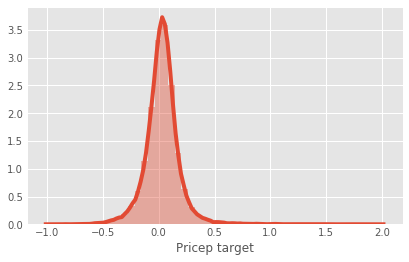

In [60]:
print(stocks['Pricep target'].describe())
sns.boxplot(stocks['Pricep target'])
plt.show()
sns.distplot(stocks['Pricep target'].dropna())

Without these errored rows our price percentage data looks remarkably normally distributed. This will work out nicely for our analysis and model.

# 4 Preparing Features Needed for CAN SLIM analysis

# C - Current Quarterly Earnings
**C** stands for Current quarterly earnings. Per share, current earnings should be up at least 25% in the most recent financial quarter, compared to the same quarter the previous year. Additionally, if earnings are accelerating in recent quarters, this is a positive prognostic sign.

--Current Earnings Should be up at least 25% compared to same quarter the previous year

--Current Earnings should be up at least 20% compared to the previous quarter

--Current Earnings should be increasly accelerating for at least 3 quarters

## Generating Annual/Quarterly EPS change features and the accelerating earnings features
To understand how much EPS changed on a quarterly and annual interval I used my functions created above to create some new features.

**EPS basical_annual** - The annual change in Earnings Per Share

**EPS basic_qchange** - The quarterly change in Earnings Per Share

**EPS basic_qperc_qacceleration** - How much is Earnings Per Share accelerating compared to previous quarters.

**EPS basic_qperc_accstreak** - How many quarters in a row is Earnings Per Share accelerating

In [23]:
ac = AnnualChange(cols=['EPS basic'])
qc = QuarterlyChange(cols=['EPS basic'])
ag = AccelIncrease(cols=['EPS basic_qperc']) #Requires the Percent change column instead of base column
stocks = ac.fit_transform(stocks)
stocks = qc.fit_transform(stocks)
stocks = ag.fit_transform(stocks)

C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:37: RuntimeWarning: divide by zero encountered in true_divide
  perc_change = np.divide(change,abs(prev[col]))
C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:37: RuntimeWarning: invalid value encountered in true_divide
  perc_change = np.divide(change,abs(prev[col]))
C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:87: RuntimeWarning: divide by zero encountered in true_divide
  perc = np.divide(change,abs(prev[col]))
C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:87: RuntimeWarning: invalid value encountered in true_divide
  perc = np.divide(change,abs(prev[col]))


Column(s) Generated : ['EPS basic_annual']
Column(s) Generated : ['EPS basic_qchange']
Columns Created : ['EPS basic_qperc_qacceleration', 'EPS basic_qperc_accstreak']


In [24]:
stocks.head(10)[['Year','Month','symbol','Price','EPS basic', 'EPS basic_qchange', 'EPS basic_qperc', 'EPS basic_annual','EPS basic_annualp','Price target', 'Pricep target', 'EPS basic_qperc_qacceleration', 'EPS basic_qperc_accstreak']]

,Year,Month,symbol,Price,EPS basic,EPS basic_qchange,EPS basic_qperc,EPS basic_annual,EPS basic_annualp,Price target,Pricep target,EPS basic_qperc_qacceleration,EPS basic_qperc_accstreak
72,2000,1,A,59.63,0.30,NaN,NaN,NaN,NaN,55.37,0.928559,NaN,NaN
71,2000,4,A,115.00,0.37,0.07,0.233333,NaN,NaN,-44.25,-0.384783,NaN,0.0
70,2000,7,A,70.75,0.34,-0.03,-0.081081,NaN,NaN,-19.84,-0.280424,-0.314414,0.0
69,2000,10,A,50.91,0.67,0.33,0.970588,NaN,NaN,2.12,0.041642,1.051669,1.0
68,2001,1,A,53.03,0.34,-0.33,-0.492537,0.04,0.133333,-13.03,-0.245710,-1.463126,0.0
67,2001,4,A,40.00,0.21,-0.13,-0.382353,-0.16,-0.432432,-6.31,-0.157750,0.110184,1.0
66,2001,7,A,33.69,-0.48,-0.69,-3.285714,-0.82,-2.411765,-8.34,-0.247551,-2.903361,0.0
65,2001,10,A,25.35,0.31,0.79,1.645833,-0.36,-0.537313,2.33,0.091913,4.931548,1.0
64,2002,1,A,27.68,-0.68,-0.99,-3.193548,-1.02,-3.000000,3.73,0.134754,-4.839382,0.0
63,2002,4,A,31.41,-0.55,0.13,0.191176,-0.76,-3.619048,-7.78,-0.247692,3.384725,1.0


## Current Earnings Should be up at least 25% compared to same quarter the previous year

Using the explore function created above I remove outliers which are outside a zcore of 2 to see the correlation of EPS Annual Increase with Price percent Increase.

C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:197: RuntimeWarning: invalid value encountered in less
  return np.abs(z_scores) < threshold


Null Count:  0 ( 0.0 %)
count    17112.000000
mean         1.708185
std          2.790149
min          0.250000
25%          0.416667
50%          0.791667
75%          1.650000
max         25.095238
Name: EPS basic_annualp, dtype: float64


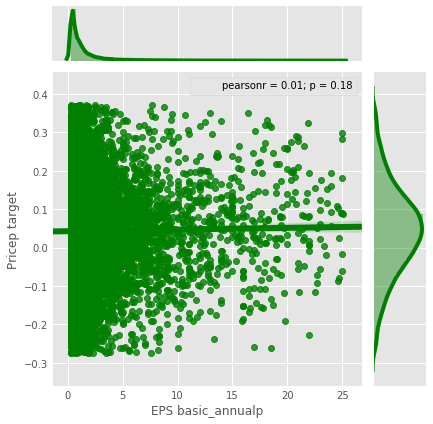

In [61]:
explore(stocks[stocks['EPS basic_annualp'] > .25], 'EPS basic_annualp',youtliers=False,ythres=2,xoutliers=False,xthres=2)

Very weak correlation for EPS Annual Percent Increase with Stock Price Percent Increase. It has a mild positive relationship, but only a r of .055. A ton of factors go into whether a stock will increase or not so we would expect to see just one column scattered like this.  

## Current Earnings Should be up at least 20% compared to the previous quarter

Checking correlation of EPS Quarterly Increase ('EPS basic_qperc')  with Price percent Increase

C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:197: RuntimeWarning: invalid value encountered in less
  return np.abs(z_scores) < threshold


Null Count:  0 ( 0.0 %)
count    17707.000000
mean         1.589362
std          2.525119
min          0.200000
25%          0.378378
50%          0.739130
75%          1.571429
max         21.900000
Name: EPS basic_qperc, dtype: float64


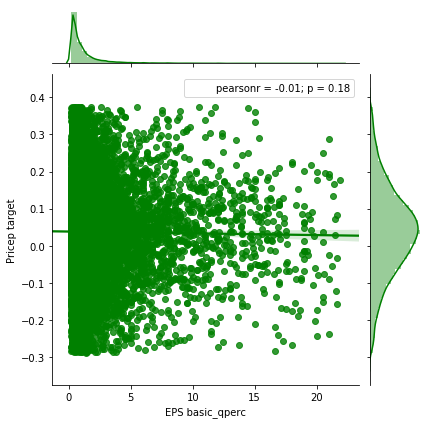

In [26]:
explore(stocks[stocks['EPS basic_qperc'] > .2], 'EPS basic_qperc',youtliers=False,ythres=2,xoutliers=False,xthres=2)

Very weak correlation between the Price percentage increase and EPS increase for the quarter.

## EPS per quarter increases should be accelerating for past 3 quarters

The stock should have accelerating Earning Per Share increases over the past 3 quarters. Below I look at each streak value to see how it correlates to stock percentage change.

C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:197: RuntimeWarning: invalid value encountered in less
  return np.abs(z_scores) < threshold


Null Count:  0 ( 0.0 %)
count    1397.000000
mean        3.080172
std         0.299260
min         3.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         6.000000
Name: EPS basic_qperc_accstreak, dtype: float64


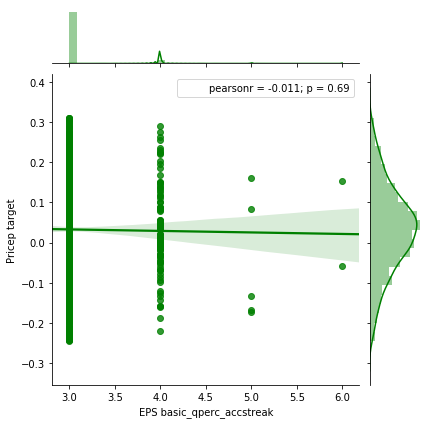

In [27]:
explore(stocks[stocks['EPS basic_qperc_accstreak'] >= 3], 'EPS basic_qperc_accstreak',youtliers=False,ythres=2)

Once again doesn't appear to be any correlation between multiple quarters of accelerating EPS increases and stock percentage price.

## All EPS Metrics Combined
Combining all the metrics above to see if the combination of all our EPS metrics correlates with stock price percentage change.

Combiend the filter would look like the following

<li>'EPS basic_annualp' >= .25</li>

<li>'EPS basic_qperc' >= .2</li>

<li>'EPS basic_qperc_accstreak' >= 3</li>

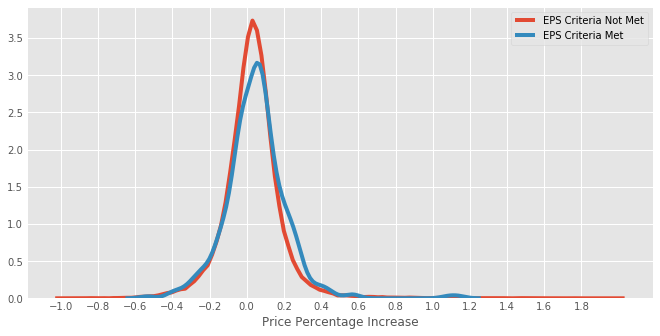

Stocks which do not meet EPS criteria
count    57048.000000
mean         0.030566
std          0.157015
Name: Pricep target, dtype: float64

Stocks which do meet EPS criteria
count    384.000000
mean       0.049324
std        0.168591
Name: Pricep target, dtype: float64


In [55]:
EPS_filter = (stocks['EPS basic_qperc'] >= .2) & (stocks['EPS basic_annualp'] >= .25) & \
            (stocks['EPS basic_qperc_accstreak'] >= 3)
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=stocks[EPS_filter == False]['Pricep target'].dropna(),label='EPS Criteria Not Met')
sns.kdeplot(data=stocks[EPS_filter]['Pricep target'].dropna(),label='EPS Criteria Met')
plt.xlabel('Price Percentage Increase')
plt.xticks(np.arange(-1,2,.2))
plt.yticks(np.arange(0,4,.5))
plt.show()
print('Stocks which do not meet EPS criteria')
print(stocks[EPS_filter == False]['Pricep target'].describe()[['count', 'mean', 'std']])
print('\nStocks which do meet EPS criteria')
print(stocks[EPS_filter]['Pricep target'].describe()[['count', 'mean', 'std']])

Only .67% (384) of the stocks in our dataset met the EPS criteria defined by CAN SLIM. The distribution bewteen the stocks that meet the EPS criteria appear similar with slightly more skew to the right for our EPS stocks. We view that the mean of the stocks which did meet the EPS Criteria is slightly higher around 5% compared to those which did not around 3%. 

## Determining if distributions are different (T-Test and Mann-Whitney U Test)
The averages vary slightly, lets run a T-Test to see if this is by chance or significant. Comparing the stocks that meet our EPS criteria with the rest of our sample. For this test I will use T-test and the Mann Whiteney U. I will use an alpha of .05 for these test. 

**T-Test** : Determines if the means of two groups are equal to each other. 

**Mann Whitney U** : The Mann-Whitney U test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.

***Null Hypothesis*** - Stocks Price Percentage change from stocks which meet the EPS Criteria are the same as stocks which don't

***Alternative Hypothesis*** - Stocks Price Percentage change from stocks which meet the EPS Criteria is different than stocks which don't

In both cases if the p value < alpha we reject the Null Hypothesis

In [29]:
stats.ttest_ind(stocks[EPS_filter == False]['Pricep target'].dropna(),stocks[EPS_filter]['Pricep target'].dropna(), equal_var=False)

Ttest_indResult(statistic=-2.1738851347084758, pvalue=0.030318528491658257)

In [30]:
stats.mannwhitneyu(stocks[EPS_filter == False]['Pricep target'].dropna(),stocks[EPS_filter]['Pricep target'].dropna())

MannwhitneyuResult(statistic=10141380.0, pvalue=0.006084282633081313)

In [31]:
stats.f_oneway(stocks[EPS_filter == False]['Pricep target'].dropna(),stocks[EPS_filter]['Pricep target'].dropna())

F_onewayResult(statistic=5.4379071026256165, pvalue=0.019707704553677662)

Our P-Values are .02 for the T-Test and .006 for the Mann Whitney U which are both less than our alpha of .05. This tells us we can reject the NULL hypothesis and conclude that the means between the stocks that meet the EPS criteria and those which don't are different.

## Testing samples
Our sample sizes are vastly different between the distributions we are comparing, i.e 57,000 for the non-EPS and 384 for the EPS. So to check to see if we get drastically different values comparing the distributions if we compared same size samples I run the t-test again 1000 times using 1000 different samples. 

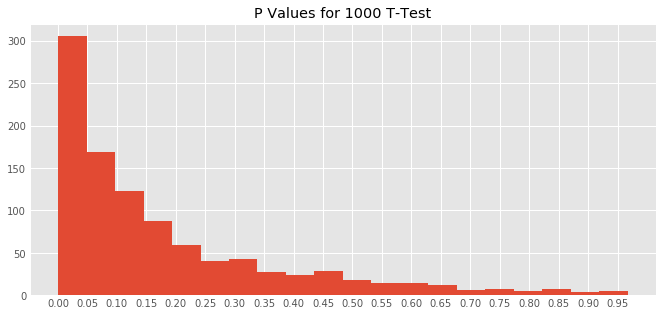

In [86]:
p_val = []
for r in range(1000):
    t, p = stats.ttest_ind(stocks[EPS_filter == False]['Pricep target'].dropna().sample(384,random_state=r),stocks[EPS_filter]['Pricep target'].dropna(), equal_var=False)
    p_val.append(p)
fig = plt.figure(figsize=(10,5))
plt.hist(p_val,bins=20)
plt.xticks(np.arange(0,1,.05))
plt.title('P Values for 1000 T-Test')
plt.show()

Although under .05 p-value was the most common value which would sugguest to reject the NULL hypothesis a lot of variability  existed depending on our sample. The Whitney Mann U and T-Test used above are non-dependent on sample size, but we can see here it does make a difference if we took a equal sample approach. This is likely due to how much variability of stock price percentage change exists among our data.

<hr />
## C - Current Quarterly Earnings Conclusion
Combining all the EPS requirements together to pick our stocks will yield stocks that have a slightly higher Price percentage increase average of 4.9% as compared to 3% of those who do not meet the requirements. This difference is signficant and not due to chance according to the T-Test and Mann Whitney U test.

This is not a major increase in stock price percentage change and we still experience a standard deviation of 16% for the price percentage change.
<hr />

# A - Annual earnings growth, 
**A** stands for Annual earnings growth, which should be up 25% or more over the last three years. Annual returns on equity should be 17% or more

--Annual Earnings Growth should be 25% or more over the last three years.

--Annual Return on Equity should be 17% or more

## Annual Earnings Growth should be 25% or more over the last three years
I will need to create the percentage change column for Earnings and check stocks which the change has been positive by at least 25% for the past 3 quarters. 

To create the percentage change column for earnings I will use my class AnnualChange.

To create the streak column I will use the class I created StreakIncrease

In [50]:
ac = AnnualChange(cols=['Earnings'],add_percent=True)
stocks = ac.fit_transform(stocks)

Column(s) Generated : ['Earnings_annual']


C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:37: RuntimeWarning: divide by zero encountered in true_divide
  perc_change = np.divide(change,abs(prev[col]))
C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:37: RuntimeWarning: invalid value encountered in true_divide
  perc_change = np.divide(change,abs(prev[col]))


In [51]:
si = StreakIncrease(cols=['Earnings_annualp'], x=.25)
stocks = si.fit_transform(stocks)

Columns Created : ['Earnings_annualp_streakgt_0.25']


C:\Users\alexa\CAN SLIM Analysis\canslim\canslim.py:197: RuntimeWarning: invalid value encountered in less
  return np.abs(z_scores) < threshold


Null Count:  0 ( 0.0 %)
count    6766.000000
mean        4.821165
std         2.374277
min         3.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: Earnings_annualp_streakgt_0.25, dtype: float64


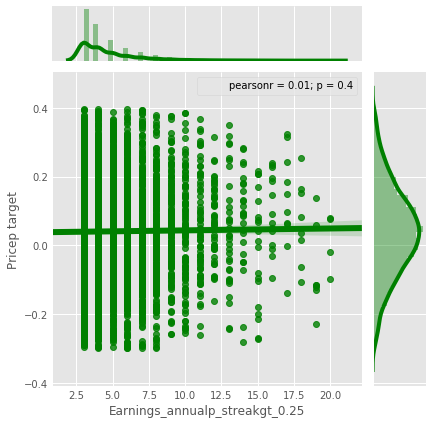

In [57]:
explore(stocks[stocks['Earnings_annualp_streakgt_0.25'] >= 3], 'Earnings_annualp_streakgt_0.25',youtliers=False,ythres=2)

No significant correlation between streaks of annual Earnings increases over 3 years. 

## Annual Return on Equity should be 17% or more
Our Return on Equity column is 'ROE'. Below I will check the correlation for ROE.

Null Count:  0 ( 0.0 %)
count    21280.000000
mean         0.283883
std          0.130194
min          0.170100
25%          0.199700
50%          0.241900
75%          0.315000
max          0.999200
Name: ROE, dtype: float64


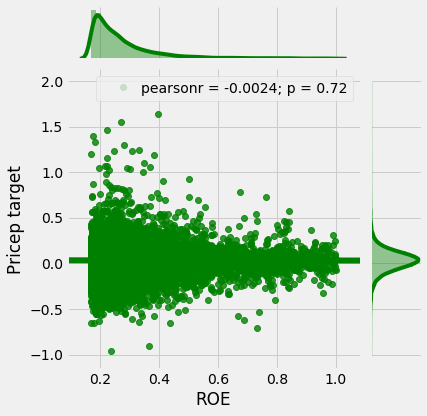

In [54]:
explore(stocks[stocks['ROE'] > .17], 'ROE')

No significant correlation between ROE and stock price percent increase.

--Current Earnings Should be up at least 25% compared to same quarter the previous year

--Current Earnings should be up at least 20% compared to the previous quarter

--Current Earnings should be increasly accelerating

--Annual Earnings Growth should be 25% or more over the last three years.

--Annual Return on Equity should be 17% or more

In [ ]:
canslim = (stocks['EPS basic_qperc'] > .2) & (stocks['EPS basic_annualp'] > .25) & \
            (stocks['EPS basic_qperc_accstreak'] >= 1) & (stocks['EPS basic_annualp_streakgt_0.25'] >= 3) \
            & (stocks['ROE'] > .17)

In [ ]:
sns.distplot(stocks[canslim]['Pricep target'].dropna())

In [ ]:
(stocks[canslim]['Pricep target'] > .2).sum()/len(stocks[canslim])